# Proyecto 03 - Sistema de recomendación de videojuegos en Steam

El objetivo del proyecto es crear un sistema de recomendación de videojuegos para la plataforma Steam, esto a partir de las reviews de los usuarios y los datos de los videojuegos.

## 0. Librerias y conformación de los datasets

In [4]:
# Importamos la librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para optimizar el uso de la RAM
import gzip
import gc #garbage collector

# Librerías para la predicción - Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


from collections import defaultdict
from surprise import Dataset
import random
from icecream import ic

In [5]:
# Definimos una función para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [8]:
# Importar los datos de las caracteristicas de los juegos

# Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000
for i, l in enumerate(parse(r'datos/steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break

In [9]:
# Importar los datos de las reviews

# Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos/steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break

In [10]:
# Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)

In [10]:
# Revisamos el dataset de reviews
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Notamos que el dataset contiene las siguientes columnas:

* username: Nombre del usuario que realiza la review
* hours: Número de horas que pasó jugando el juego hasta el momento de la review
* products: Cantidad de productos adquiridos por el usuario
* product_id: Código del producto al que le corresponde la review
* page_order: 
* date: Fecha de la reseña
* text: Texto de la reseña
* early_acces: Indica si el usuario recibió acceso temprano al juego o no
* page: página donde se encuentra la reseña
* found_funny: Cantidad de personas que marcaron la reseña como "divertida"
* compensation: Si el juego fue recibido de forma gratuita o no
* user_id: Código de identificación para el usuario

Vamos a limpiar un poco el dataset quitando las columnas que no nos interesan

In [11]:
df_rev = df_rev.drop(columns=['page_order','early_access','page','found_funny','compensation', 'date', 'text'])

También eliminamos aquellas isntancias que se encuentran repetidas en el dataset

In [12]:
# Eliminamos filas duplicadas
df_rev = df_rev.drop_duplicates()

In [13]:
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
99993,apotterx1,1.3,11.0,461560,NaN
99994,Gargoylenbe ✌,0.6,259.0,461560,NaN
99995,edvineriS,0.9,34.0,461560,76561198215396451
99999,MeltDown,1.3,223.0,233270,NaN


Luego, veamos las medidas estadísticas que podemos obtener del dataset

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


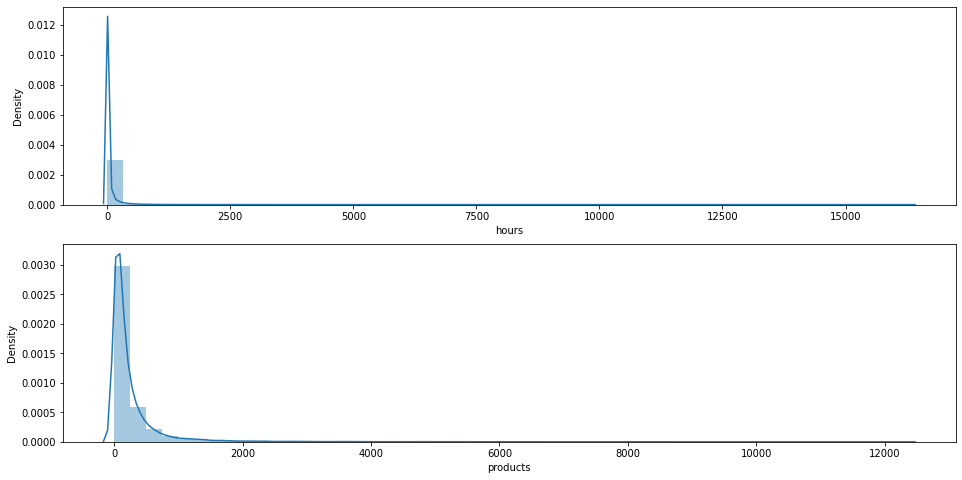

In [14]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

No es posible apreciar de manera adecuada una distribución de las variables debido a la gran cantidad de datos extremos que tiene en su cola derecha, por lo cual vamos a hacer una limpieza de esta cola con ayuda del rango intercuartílico

In [14]:
# Definimos las columnas sobre las cuales haremos la limpieza
cols_df_rev = ['hours', 'products']

for a in range(len(cols_df_rev)):
    # Determinamos el cuartil 25
    Q1 = df_rev[cols_df_rev[a]].quantile(0.25)
    # Determinamos el cuartil 75
    Q3 = df_rev[cols_df_rev[a]].quantile(0.75)
    # Determinamos el rango intercuartil
    IQR = Q3 - Q1
    # Filtramos los valores
    filter = (df_rev[cols_df_rev[a]] <= Q3 + 3 * IQR)
    df_rev = df_rev.loc[filter]

# Muestra las dimensiones del nuevo dataset
print(df_rev.shape)

(82635, 5)


/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


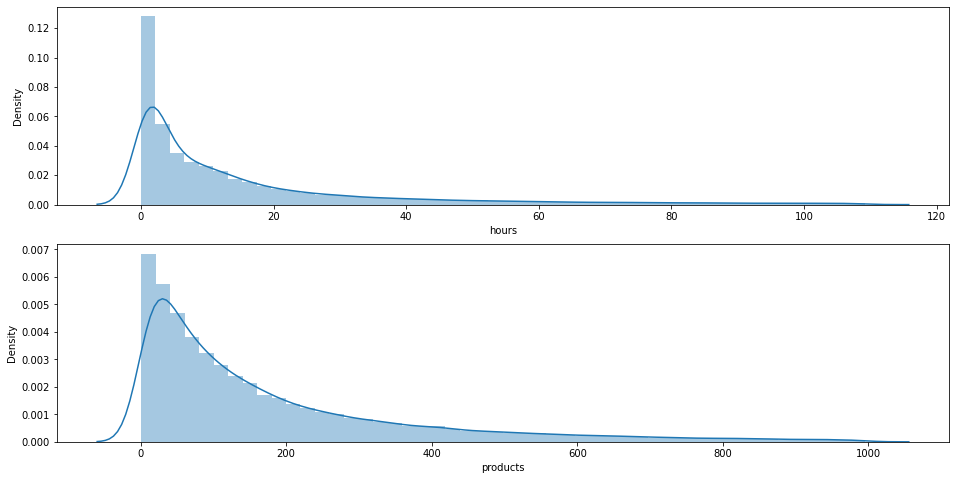

In [16]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

Aquí podemos observar claramente que tiene la forma de una ley de potencias, donde la mayor cantidad de datos se concentran en menor cantidad de productos y de horas jugadas.

In [15]:
df_rev.describe()

,hours,products
count,82635.000000,82635.000000
mean,15.652988,177.608217
std,21.210575,194.662282
min,0.000000,1.000000
25%,1.800000,41.000000
50%,7.300000,106.000000
75%,19.800000,242.000000
max,109.200000,995.000000


Ahora miraremos los datos faltantes de cada columna

In [16]:
from prettytable import PrettyTable

valNan = PrettyTable()

valNan.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_rev)):
    valNan1 = df_rev[cols_df_rev[a]].isna().sum()
    valNan.add_row([cols_df_rev[a],valNan1])

print(valNan)

+----------+---------------------+
| Columna  | # Valores faltantes |
+----------+---------------------+
|  hours   |          0          |
| products |          0          |
+----------+---------------------+


Para continuar con el análisis, haremos el mismo análisis para el dataset con la información de los juegos para luego relacionarlos

In [17]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Las columnas del dataset son:

* <b>publisher:</b> Contiene el nombre del editor 
* <b>genres:</b> Contiene información sobre los géneros que están asociados
* <b>app_name:</b> El nombre 
* <b>title:</b> El título
* <b>url:</b> Dirección web donde se encuentra
* <b>release_date:</b> Fecha de lanzamiento
* <b>tags:</b> Etiquetas colocadas para encontrar el juego
* <b>discount_price:</b> Precio con descuento
* <b>reviews_url:</b> Dirección web de las reseñas
* <b>specs:</b> Especificaciones del juego
* <b>price:</b> Precio full
* <b>early_access:</b> Si el juego tuvo "acceso anticipado" o no
* <b>id:</b> Código de identificación del juego
* <b>developer:</b> Contiene el nombre del desarrollador
* <b>sentiment:</b>
* <b>metascore:</b> 

Antes de eliminar las columnas que no son relevantes del dataset, vamos a ver los datos faltantes y así determinar qué columnas dejar o borrar, debido a que columnas como `"app_names"` y `"title"` parecen contener la misma información, al igual que `"publisher"` y `"developer"`

In [18]:
cols_df_games = list(df_games.columns)
valNan2 = PrettyTable()

valNan2.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_games)):
    valNan3 = df_games[cols_df_games[a]].isna().sum()
    valNan2.add_row([cols_df_games[a],valNan3])

print(valNan2)

+----------------+---------------------+
|    Columna     | # Valores faltantes |
+----------------+---------------------+
|   publisher    |         8052        |
|     genres     |         3283        |
|    app_name    |          2          |
|     title      |         2050        |
|      url       |          0          |
|  release_date  |         2067        |
|      tags      |         163         |
| discount_price |        31910        |
|  reviews_url   |          2          |
|     specs      |         670         |
|     price      |         1377        |
|  early_access  |          0          |
|       id       |          2          |
|   developer    |         3299        |
|   sentiment    |         7182        |
|   metascore    |        29458        |
+----------------+---------------------+


Eliminamos las columnas que no son relevantes para el fin de este proyecto

In [19]:
# Eliminamos las columnas que no son relevantes
df_games = df_games.drop(columns=['publisher', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs',
                                  'price', 'early_access', 'sentiment', 'metascore', 'genres'])

In [20]:
# Eliminamos las instancias sin valor de 'id' y de 'app_name'

df_games = df_games.dropna(subset=['id', 'app_name'])

In [21]:
df_games

,app_name,id,developer
0,Lost Summoner Kitty,761140,Kotoshiro
1,Ironbound,643980,Secret Level SRL
2,Real Pool 3D - Poolians,670290,Poolians.com
3,弹炸人2222,767400,彼岸领域
4,Log Challenge,773570,NaN
...,...,...,...
32130,Colony On Mars,773640,"Nikita ""Ghost_RUS"""
32131,LOGistICAL: South Africa,733530,Sacada
32132,Russian Roads,610660,Laush Dmitriy Sergeevich
32133,EXIT 2 - Directions,658870,"xropi,stev3ns"


Ahora, vamos a juntar ambos datasets

In [22]:
df_games = df_games.rename(columns={"id": "product_id"})

In [23]:
df_steam = df_rev.merge(df_games, on="product_id")

In [24]:
## encodeamos el username para tener ids en numeros.
from sklearn.preprocessing import OrdinalEncoder
array = df_steam.username.astype(str)
oe = OrdinalEncoder()
users = oe.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)

df_steam.insert(0,'userid', users)

## borramos las ids viejas
df_steam.drop(columns=['user_id'], inplace=True)

In [64]:
df_steam

,userid,username,hours,products,product_id,app_name,developer
0,8554,Chaos Syren,0.1,41.0,725280,Psi Project,Vyacheslav Shilikhin
1,46505,Teef 🐏,0.9,923.0,725280,Psi Project,Vyacheslav Shilikhin
2,43546,Sneaky_Panda,0.6,243.0,725280,Psi Project,Vyacheslav Shilikhin
3,70402,wasp99rock,0.3,48.0,725280,Psi Project,Vyacheslav Shilikhin
4,72312,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,Gunspell - Steam Edition,Ino-Co Plus
...,...,...,...,...,...,...,...
82630,4094,AtlasDiesIrae,3.6,150.0,296930,Ascendant,Hapa Games
82631,36011,Phelyne,4.4,296.0,296930,Ascendant,Hapa Games
82632,47634,TheChaox,5.5,48.0,296930,Ascendant,Hapa Games
82633,10254,Crop Duster,54.7,135.0,296930,Ascendant,Hapa Games


In [65]:
df_steam.isna().sum()

userid         0
username       0
hours          0
products       0
product_id     0
app_name       0
developer     64
dtype: int64

In [66]:
df_steam_nd = df_steam[df_steam['developer'].isna() == True]['app_name'].value_counts()
df_steam_nd

Steam Dev Days                                   20
Streamer Simulator                               14
Creature Factory 2                                7
In The Shadow                                     6
Hit & Run                                         6
Gamer                                             3
Poco's Udon World                                 3
Robotpencil Presents: Improving Your Line Art     2
The Haunting in Connecticut                       1
Galapagos Evolution                               1
After Dark Original: Area 51                      1
Name: app_name, dtype: int64

Notamos que uno de los "juegos" al que le falta el valor de desarrollador se llama "Steam Dev Days", el cual es en realidad una conferencia que realiza la compañía y no un juego como tal, por lo tanto lo más recomendable sería hacer una categorización por géneros que no tengan etiquetas relacionadas a estos, tales como "documentary"

Siguiendo con el análisis, vamos a eliminar aquellas instancias con datos faltantes debido a que no son una porción representativa de nuestro total de datos

In [67]:
df_steam = df_steam.dropna()

In [68]:
df_steam.isna().sum()

userid        0
username      0
hours         0
products      0
product_id    0
app_name      0
developer     0
dtype: int64

In [31]:
df_steam.groupby('app_name').mean()

,userid,hours,products
app_name,,,
A Room Beyond,37537.250000,8.300000,141.750000
A Timely Intervention,52585.600000,9.220000,390.800000
A Valley Without Wind,35207.649351,13.965801,415.701299
Abscond,27072.500000,1.350000,145.500000
Action Henk,34050.324138,10.353103,276.010345
...,...,...,...
[the Sequence],43299.163636,8.960000,248.127273
fault - milestone one,36810.177083,9.130506,214.687500
interLOGIC,47079.272727,2.545455,486.727273


In [69]:
df_games

,app_name,product_id,developer
0,Lost Summoner Kitty,761140,Kotoshiro
1,Ironbound,643980,Secret Level SRL
2,Real Pool 3D - Poolians,670290,Poolians.com
3,弹炸人2222,767400,彼岸领域
4,Log Challenge,773570,NaN
...,...,...,...
32130,Colony On Mars,773640,"Nikita ""Ghost_RUS"""
32131,LOGistICAL: South Africa,733530,Sacada
32132,Russian Roads,610660,Laush Dmitriy Sergeevich
32133,EXIT 2 - Directions,658870,"xropi,stev3ns"


# Analisis exploratorio de datos

In [29]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82635 entries, 0 to 100000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   username    82635 non-null  object 
 1   hours       82635 non-null  float64
 2   products    82635 non-null  float64
 3   product_id  82635 non-null  object 
 4   user_id     33058 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.8+ MB


## Analisis de datos de info games
- Se ve que las variables de discount_price y las de metascore faltan mucho
- Se observa que esta la feature "sentiment" que nos dice el rating general de el juego
- El nombre del juego es la feature 'title' pero tambien "app name" se puede usar como substituto
- los atributos generos y tags son muy parecidos entre si, solo que genero es solamente tiene los generos de los juegos, pero por esta razon tiene mas naans que tags
- Hay caracteres no occidentales y emojis asi que hay que tener cuidado con los errores de encoding

In [30]:
df_rev.info()
df_rev.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82635 entries, 0 to 100000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   username    82635 non-null  object 
 1   hours       82635 non-null  float64
 2   products    82635 non-null  float64
 3   product_id  82635 non-null  object 
 4   user_id     33058 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.8+ MB


,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075


# Preprocesamiento de datos


In [31]:
## eliminamos a las reviews que tengan 0 horas jugadas, pues no da una buena señal de
## la confiabilidad de su review, por que son pocos, y por que
## limita el encoding que queremos hacer
print(df_steam[~(df_steam['hours']==0)].size - df_steam.size)
df_steam = df_steam[~(df_steam['hours']==0)]

-378


(0.0, 100.0)

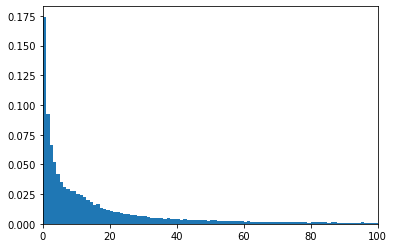

In [32]:
## Vemos la distribucion actual de los datos
df_steam.hours
plt.hist(x=df_steam.hours, bins=100, density=True, range=(0,100))
plt.xlim([0,100])

In [33]:
## lo que tenemos aqui es una distribucion
## de 'power law' o 'right skewed' que vamos a encodear
## primero sacandole su logaritmo para hacerla mas parecida
## a una distribucion gausiana y despues la encodeamos con las
## herramientas de sklearn.

df_steam['log_hours'] = np.log(df_steam.hours)

(-5.0, 10.0)

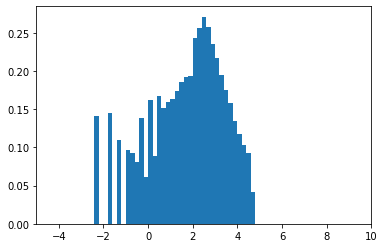

In [34]:
## escalado logaritmico
plt.hist(x=df_steam.log_hours, bins=100, density=True, range=(-10,10))
plt.xlim([-5,10])

In [35]:
# Encoding sklearn. De 1 a 10 para que queden como si fuera
# una review y que Surprise pueda leerlas correctamente

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_steam.log_hours).reshape(-1, 1))
df_steam['escalados'] = dataset

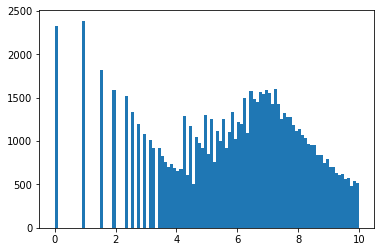

In [36]:
# resultado final de los datos
plt.hist(x=df_steam.escalados, bins=100)
plt.show()

In [37]:
df_steam

,userid,username,hours,products,product_id,app_name,developer,log_hours,escalados
0,8554,Chaos Syren,0.1,41.0,725280,Psi Project,Vyacheslav Shilikhin,-2.302585,0.000000
1,46505,Teef 🐏,0.9,923.0,725280,Psi Project,Vyacheslav Shilikhin,-0.105361,3.140792
2,43546,Sneaky_Panda,0.6,243.0,725280,Psi Project,Vyacheslav Shilikhin,-0.510826,2.561205
3,70402,wasp99rock,0.3,48.0,725280,Psi Project,Vyacheslav Shilikhin,-1.203973,1.570396
4,72312,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,Gunspell - Steam Edition,Ino-Co Plus,3.933784,8.914491
...,...,...,...,...,...,...,...,...,...
82630,4094,AtlasDiesIrae,3.6,150.0,296930,Ascendant,Hapa Games,1.280934,5.122411
82631,36011,Phelyne,4.4,296.0,296930,Ascendant,Hapa Games,1.481605,5.409257
82632,47634,TheChaox,5.5,48.0,296930,Ascendant,Hapa Games,1.704748,5.728226
82633,10254,Crop Duster,54.7,135.0,296930,Ascendant,Hapa Games,4.001864,9.011806


# Modelo de sistema de recomendacion

In [38]:
#### Preparacion del dataset objeto de Surprise
### Orden de las features
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_steam[['userid', 'product_id', 'escalados']] #date lacking
## crear una copia del dataset por seguridad
df_reader_og = df_steam[['userid', 'product_id', 'escalados', 'username']]
df_reader

,userid,product_id,escalados
0,8554,725280,0.000000
1,46505,725280,3.140792
2,43546,725280,2.561205
3,70402,725280,1.570396
4,72312,328100,8.914491
...,...,...,...
82630,4094,296930,5.122411
82631,36011,296930,5.409257
82632,47634,296930,5.728226
82633,10254,296930,9.011806


In [39]:
## Creacion objeto reader y el dataset 
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [40]:
## Separar sets de entrenamiento y testeo
trainset, testset = train_test_split(data, test_size=.25)

In [41]:
### Testear el algoritmo en el dataset
algo = SVD()

resultados = pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
#resultados

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9141  1.9111  1.9251  1.9285  1.9129  1.9183  0.0070  
MAE (testset)     1.4749  1.4743  1.4837  1.4812  1.4730  1.4774  0.0042  
Fit time          5.35    5.19    5.15    5.06    5.17    5.18    0.09    
Test time         0.12    0.13    0.28    0.12    0.12    0.15    0.06    


In [ ]:
## funcion para traducir los resultados de la funcion 'predecir()'
def traducir(preds):
    rows_list = []
    ## coger el username por medio de los indices
    for user in preds:
        index_user = df_reader.loc[df_reader.userid == user].index[0]
        username = df_reader_og[df_reader_og.index == index_user].username.values[0]
    ## coger el titulo del juego y el rating
        revs = preds[user]
        for game_id, score in revs:
            game_name = df_games.loc[df_games.product_id == game_id].app_name.values[0]
            ## transformar el score a horas
            hours = np.exp(score)
            ## anadirlo al data frame
            dict = {
                'usename':username,
                'game_id':game_name,
                'expected_hours':hours
            }
            rows_list.append(dict)
    df = pd.DataFrame(rows_list)
    return df

In [45]:
### definir funcion para que prediga un numero de peliculas al azar
### con el dataset

def predecir(dataset,
            algo,
            n_random_games=15,
            n_random_users=50,
            top=5,
            game_ids=0,
            user_ids=0,
            predicts=10):
    '''
    Esta funcion crea un diccionario con predicciones que los usuarios no han 
        rateado.
    - num_predicts: es el numero de predicciones que hacer para cada usuario
    - user_ids: el id de las personas, si rand_users es True, no hay que poner            user_ids.
    - rand_users: si coger a usuers al azar para hacer predicciones.
    - dataset: el dataset con las predicciones con las que se entrena el modelo. en       nuestro caso "df_reader".
    - algo: el algoritmo que se va a use. En nuesto caso "algo2".
    '''
    predicted = defaultdict(list)
    ## if the input is empty or 0 get random get random items
    total_games = len(dataset.product_id.value_counts().index)
    total_users = len(dataset.userid.value_counts().index)
    if game_ids==0:
        if n_random_games > total_games:
            n_random_games = total_games
        j = dataset.product_id.value_counts().index
        game_ids=random.sample(list(j), n_random_games)
    if user_ids==0:
        if n_random_users > total_users:
            n_random_users = total_users
        u = dataset.userid.value_counts().index
        user_ids = random.sample(list(u), n_random_users)

    ### loop trough users and games and append to 'predicted'
    for user in user_ids:
        for game in game_ids:
            ## skipear si ya habia rateado el juego
            v = dataset.loc[(dataset.userid == user) & (dataset.product_id == game)]
            if len(v) == 0:
                ## predict and append the predictions
                pred = algo.predict(user, game)
                predicted[pred[0]].append((pred[1],pred[3]))

    # sort the predictions for each user
    for uid, user_ratings in predicted.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        predicted[uid] = user_ratings[:top]
    return traducir(predicted)



In [46]:
## probar la funcion y coger un pequeno dataset ara traducir
predecir(df_reader, algo, n_random_games=300, n_random_users=2)
